# Medicinal Plant Leaf Image Analysis - Tensorflow/Keras

# Data Processing for a dataset that has training and validation sub-folders defined

We are going to use medicinal plant leaf image dataset (https://www.kaggle.com/datasets/bijlyborkatullah/medicinal-plant-bijly-withbg/data) to illustrate the data processing and model preparation. Also, we are going to use  here a pre-trained inception(InceptionV3) model with custom layers on top of it for analysis & prediction of the medicinal plants data.

# All common imports

In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras import layers
import os

# Generic function to return training and validation dataset

In [2]:
# grader-required-cell

#The below function takes in the folder path of the training and validation subfolders as arguments

# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=50,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1/255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=50,
                                                                class_mode='categorical',
                                                                target_size=(224, 224))
  ### END CODE HERE
  return train_generator, validation_generator

In [3]:
TRAINING_DIR = "./tmp/medicinal-images-2/Train/"
VALIDATION_DIR = "./tmp/medicinal-images-2/Validation/"
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 3565 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


# Building a model - This uses a custom layered model on top of an inceptionV3(pre-trained) model 

In [8]:
# grader-required-cell

# GRADED FUNCTION: create_model
def create_model():
  ### Using the inception model as base while creating layers on top of it
  local_weights_file = './tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

  pre_trained_model = InceptionV3(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = None)

  # Load the pre-trained weights you downloaded.
  pre_trained_model.load_weights(local_weights_file)

  # Freeze the weights of the layers.
  for layer in pre_trained_model.layers:
     layer.trainable = False

  # Choose `mixed7` as the last layer of your base model
  last_layer = pre_trained_model.get_layer('mixed7')
  #print('last layer output shape: ', last_layer.output_shape)
  last_output = last_layer.output

  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.1)(x) #This is to minimize the model to overfit by randomly de-activating 10% of neurons
  x = layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.1)(x)                  
  # Add a final sigmoid layer for classification
  x = layers.Dense  (10, activation='softmax')(x)    
    
  model = Model(pre_trained_model.input, x) 
  
  model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  ### END CODE HERE

  return model

# Train the model

In [9]:
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
72/72 [==============================] - 460s 6s/step - loss: 3.6256 - accuracy: 0.6025 - val_loss: 0.5009 - val_accuracy: 0.8060
Epoch 2/15
72/72 [==============================] - 408s 6s/step - loss: 0.4157 - accuracy: 0.8701 - val_loss: 0.2416 - val_accuracy: 0.9200
Epoch 3/15
72/72 [==============================] - 403s 6s/step - loss: 0.3380 - accuracy: 0.9125 - val_loss: 0.2047 - val_accuracy: 0.9380
Epoch 4/15
72/72 [==============================] - 452s 6s/step - loss: 0.1952 - accuracy: 0.9338 - val_loss: 0.3317 - val_accuracy: 0.9500
Epoch 5/15
72/72 [==============================] - 415s 6s/step - loss: 0.1489 - accuracy: 0.9551 - val_loss: 0.3255 - val_accuracy: 0.9220
Epoch 6/15
72/72 [==============================] - 423s 6s/step - loss: 0.1554 - accuracy: 0.9585 - val_loss: 0.3087 - val_accuracy: 0.9360
Epoch 7/15
72/72 [==============================] - 430s 6s/step - loss: 0.1639 - accuracy: 0.9619 - val_loss: 0.2871 - val_accuracy: 0.9340
Epoch 8/15
72

# Plot the accuracy

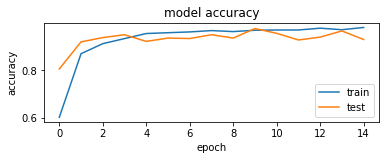

In [10]:
import matplotlib.pyplot as plot
plot.subplot(2,1,1)
plot.plot(history.history['accuracy'])
plot.plot(history.history['val_accuracy'])
plot.title('model accuracy')
plot.ylabel('accuracy')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='lower right')

# Plot the loss


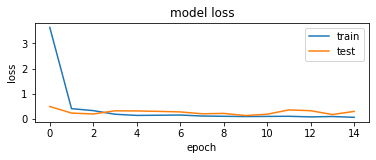

In [11]:
plot.subplot(2,1,2)
plot.plot(history.history['loss'])
plot.plot(history.history['val_loss'])
plot.title('model loss')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='upper right')

In [38]:
medicinal_leaf_labels = os.listdir("./tmp/medicinal-images-2/Train")
print(medicinal_leaf_labels)

['Bohera', 'Devilbackbone', 'Haritoki', 'Lemongrass', 'Nayontara', 'Neem', 'Pathorkuchi', 'Thankuni', 'Tulsi', 'Zenora']


# Make predictions using above model

1/1 [==============================] - 0s 113ms/step


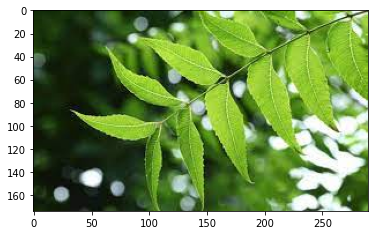

Medicinal Plant is Neem


In [39]:
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

fn="neem1.jpg"
image_path='./sample_dir_creation/' + fn

image = tf.keras.utils.load_img(image_path, target_size=(224, 224))
x=img_to_array(image)
x /= 255.0
x=np.expand_dims(x, axis=0)
classes = model.predict(x)

img = mpimg.imread(image_path)
plt.imshow(img)

plt.show()

category=np.array(classes[0]).argmax()
print("Medicinal Plant is " + medicinal_leaf_labels[category])
